# About

In this notebook, we will examine the transfer matrix between two LDA models.

https://towardsdatascience.com/style-pandas-dataframe-like-a-master-6b02bf6468b0

In [1]:
from importlib import reload
import sys
import re
import matplotlib.pyplot as pl
import numpy as np
import scipy
import pandas as pd
import itertools
from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
import types
sys.path.extend(["../src", "."])

In [2]:
import dblp
import helper
reload(dblp)
reload(helper)
print("reloaded")

reloaded


In [3]:
dct = helper.load_dct("inproceedings")

# Transfer Matrix

Here, we train two LDA models.  Let $M_i$ be their respective topic-term matrices of the shape $(k, N)$ where $k$ is the number of topics
and $N$ the number of terms.

We imagine a transfer matrix $A$ such that:

$$ M_\mathrm{to} = AM_\mathrm{from} $$

The transfer matrix can be computed by performing pseudo inverse on $M_\mathrm{from}$, which is done using singular value decomposition.

$$ A = M_\mathrm{to}V\Sigma^{-1} U^T $$

So, $A$ transfers the topics from one topic space to another.  Using the transfer matrix, we can study the dynamics between the two topic models.

## Future excitation

Let's consider a case that $A$ transfers a past topic model to a future topic model.  Here, we have
$M_\mathrm{from}$ is the LDA model from 2000 to 2002, and $M_\mathrm{to}$ is the LDA model from 2018 to 2019.

The objective is to investigate the future evolution of each from-topics.  This is done by considering the
input topic vector as $\delta_i = [0 \dots 0 1 0 \dots 0]$ where only the $i$-th topic is 1, and all other topics are zeros.

The output topic, according to the transfer matrix is given by $A_i$, the $i$-th column of $A$.  The degree of excitation can be measured as the norm $\|A_i\|$.

Therefore, we have a measure on the _future_ prospect of _each_ source topic.

In [20]:
num_topics=50
model1 = helper.ldamodel("inproceedings", dct, num_topics, query={"year":"<> 1998 2000"}, model_name="m1")
model2 = helper.ldamodel("inproceedings", dct, num_topics, query={"year":"<> 2010 2013"}, model_name="m2")

building name... inproceedings
  done in 17.88 seconds
building name... inproceedings
  done in 56.53 seconds


In [6]:
M1 = model1.get_topics()
M2 = model2.get_topics()

In [7]:
M1.shape, M2.shape

((20, 35327), (20, 35327))

In [8]:
A = helper.transfer_matrix(M_from=M1, M_to=M2)

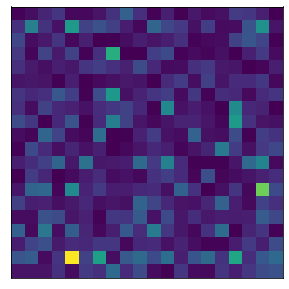

In [9]:
helper.imshow(np.abs(A))

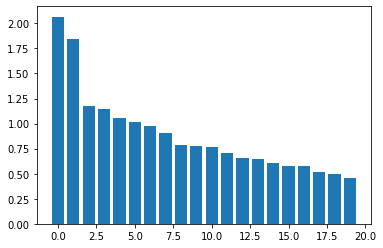

In [10]:
A_norms = np.linalg.norm(A.T@A, axis=0)
I = np.argsort(-A_norms)
pl.bar(np.arange(num_topics), A_norms[I]);

In [11]:
# Package it into a dataframe
num_words = 14
topic_words = dict(helper.topic_words(M1, dct, num_words=num_words))
data = [[i, A_norms[i]] + topic_words[i] for i in I]
df = pd.DataFrame(data=data, columns=['topic', 'residue']+["word%d"%i for i in range(num_words)]).set_index('topic')
df.head(10).style.bar(subset=['residue'])

## Past progression

It's important to see how a topic came about.  We can compute the transfer matrix:

$$ B = A^{-1} $$

Using $B$ as the _reverse_ transfer matrix, we can analyze where the topics are coming from.

array([12,  5, 16, 10, 15,  4,  0, 19, 14, 13])

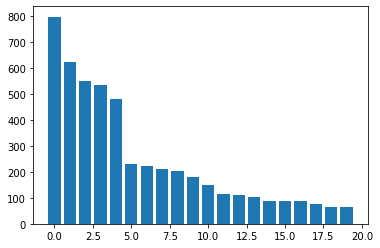

In [12]:
B = np.linalg.inv(A)
B_norms = np.linalg.norm(B.T @ B, axis=0)
J = np.argsort(-B_norms)
pl.bar(np.arange(num_topics), B_norms[J]);
J[:10]

In [14]:
helper.topic_words(M2, dct, topic=J[0])

[[12,
  ['using',
   'based',
   'multi',
   'view',
   'optimization',
   'new',
   'design',
   'problem',
   'space',
   'analysis']]]

In [15]:
# Package it into a dataframe
num_words = 13
topic_words = dict(helper.topic_words(M2, dct, num_words=num_words))
data = [[i, B_norms[i]] + topic_words[i] for i in J]
df_inv = pd.DataFrame(data=data, columns=['topic', 'residue']+["word%d"%i for i in range(num_words)]).set_index('topic')
df_inv.head(10).style.bar(subset=['residue'])

# Spectral analysis

Here, we are interested in the very optimal preservation of topics by the transfer matrix.

$$\mu = \max\left(\frac{\|A x\|}{\|x\|}\right)$$

Let $x^*$ be the unit-vector that achieves $\mu$.  The quantity $\mu$ measures how well $A$ can preserve the intensity for the
very specific topic mixture $x^*$.

We know that $(\mu, x^*) = \mathrm{eig}_1(A^T A)$.

In [16]:
(s, v) = np.linalg.eig(A.T @ A)

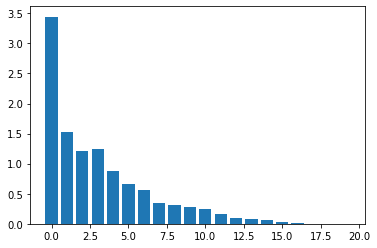

In [17]:
pl.bar(np.arange(num_topics), s);

In [18]:
x = v[0]
K = np.argsort(-x)
K[:10]

array([13, 14, 12,  4,  9,  7,  1,  6,  5, 17])

In [19]:
num_words = 20
topic_words = dict(helper.topic_words(M1, dct, num_words=num_words))
data = [[i, x[i]] + topic_words[i] for i in K]
df_inv = pd.DataFrame(data=data, columns=['topic', 'residue']+["word%d"%i for i in range(num_words)]).set_index('topic')
df_inv.head(20).style.bar(subset=['residue'])

It's probably not very realistic to assume that a work span so many topics.  So, one may argue that the spectral analysis of the transfer matrix is not as relevant.

### 